In [1]:
import pandas as pd

In [2]:
agent_df = pd.read_pickle('agent_output.pkl')
joint_calendar_df = pd.read_pickle('joint_calendar.pkl')

In [3]:
# Reset index and move it to columns
agent_df = agent_df.reset_index()

# Subtract 52 from 'Step' column to start from 0
agent_df['Step'] = agent_df['Step'] - 52

# Set 'Step' and 'AgentID' back as indices
agent_df.set_index(['Step', 'AgentID'], inplace=True)

# Reset index and move it to columns
agent_df_reset = agent_df.reset_index()

# Create a date range starting from '2021-01-03' with a frequency of one week
# The number of periods is the number of unique 'Step' values in agent_df
dates = pd.date_range(start='2021-01-03', periods=agent_df_reset['Step'].nunique(), freq='W')

# Create a DataFrame mapping 'Step' to 'Date'
step_to_date = pd.DataFrame({'Step': range(0, len(dates)), 'Date': dates})

# Merge this DataFrame with agent_df to add the 'Date' column
agent_df_reset = agent_df_reset.merge(step_to_date, on='Step')

# Set 'Step' and 'AgentID' back as indices
agent_df = agent_df_reset.set_index(['Step', 'AgentID'])

In [4]:
def calculate_total_purchases(agent_df):
    '''
    Computes total purchases per brand per step from agent level output
    Used as sanity check for model level output
    '''
    # Initialize empty lists to store the results
    total_purchases_A = []
    total_purchases_B = []
    dates = []
    steps = []

    # Iterate over the 'Purchased_This_Step' column
    for index, row in agent_df.iterrows():
        # Append the number of purchases for each brand to the respective list
        total_purchases_A.append(row['Purchased_This_Step']['A'])
        total_purchases_B.append(row['Purchased_This_Step']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the total purchases for each brand
    total_purchases_df = pd.DataFrame({
        'Total_Purchases_A': total_purchases_A,
        'Total_Purchases_B': total_purchases_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and sum the purchases
    total_purchases_df = total_purchases_df.groupby(['Date']).sum().reset_index()

    return total_purchases_df

In [5]:
total_purchases_df = calculate_total_purchases(agent_df)

In [6]:
# Calculate total dollar sales for Brand A and Brand B and add them to the total_purchases_df
# Also add price, tv and web ad spend columns for A and B to the total_purchases_df dataframe
total_purchases_df['Price_A'] = joint_calendar_df[('A', 'price')]
total_purchases_df['Price_B'] = joint_calendar_df[('B', 'price')]
total_purchases_df['TV_A'] = joint_calendar_df[('A', 'TV')]
total_purchases_df['Web_A'] = joint_calendar_df[('A', 'Web')]
total_purchases_df['TV_B'] = joint_calendar_df[('B', 'TV')]
total_purchases_df['Web_B'] = joint_calendar_df[('B', 'Web')]
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Purchases_A'] * total_purchases_df['Price_A']
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Purchases_B'] * total_purchases_df['Price_B']


In [7]:
# Set correct data types
total_purchases_df['Price_A'] = total_purchases_df['Price_A'].astype(float)
total_purchases_df['Price_B'] = total_purchases_df['Price_B'].astype(float)
total_purchases_df['Total_Purchases_A'] = total_purchases_df['Total_Purchases_A'].astype(float)
total_purchases_df['Total_Purchases_B'] = total_purchases_df['Total_Purchases_B'].astype(float)
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Sales_A'].astype(float)
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Sales_B'].astype(float)
total_purchases_df['TV_A'] = total_purchases_df['TV_A'].astype(float)
total_purchases_df['Web_A'] = total_purchases_df['Web_A'].astype(float)
total_purchases_df['TV_B'] = total_purchases_df['TV_B'].astype(float)
total_purchases_df['Web_B'] = total_purchases_df['Web_B'].astype(float)

In [8]:
total_purchases_df

,Date,Total_Purchases_A,Total_Purchases_B,Price_A,Price_B,TV_A,Web_A,TV_B,Web_B,Total_Sales_A,Total_Sales_B
0,2021-01-03,564.0,215.0,5.0,5.0,0.0,0.0,0.0,0.0,2820.0,1075.0
1,2021-01-10,578.0,250.0,5.0,5.0,0.0,0.0,0.0,0.0,2890.0,1250.0
2,2021-01-17,598.0,258.0,5.0,5.0,0.0,0.0,0.0,0.0,2990.0,1290.0
3,2021-01-24,603.0,246.0,5.0,5.0,0.0,0.0,0.0,0.0,3015.0,1230.0
4,2021-01-31,601.0,261.0,5.0,5.0,100000.0,0.0,0.0,0.0,3005.0,1305.0
...,...,...,...,...,...,...,...,...,...,...,...
203,2024-11-24,518.0,806.0,5.0,2.5,0.0,0.0,0.0,120000.0,2590.0,2015.0
204,2024-12-01,471.0,436.0,5.0,2.5,0.0,0.0,0.0,120000.0,2355.0,1090.0
205,2024-12-08,467.0,439.0,5.0,2.5,0.0,0.0,0.0,120000.0,2335.0,1097.5
206,2024-12-15,449.0,466.0,5.0,5.0,0.0,0.0,0.0,0.0,2245.0,2330.0


In [9]:
data_A = total_purchases_df[['Date','Total_Sales_A','Price_A','TV_A','Web_A']]

In [11]:
data_A['Day_of_Year'] = data_A['Date'].dt.dayofyear
data_A

/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_10726/1674639562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_A['Day_of_Year'] = data_A['Date'].dt.dayofyear


,Date,Total_Sales_A,Price_A,TV_A,Web_A,Day_of_Year
0,2021-01-03,2820.0,5.0,0.0,0.0,3
1,2021-01-10,2890.0,5.0,0.0,0.0,10
2,2021-01-17,2990.0,5.0,0.0,0.0,17
3,2021-01-24,3015.0,5.0,0.0,0.0,24
4,2021-01-31,3005.0,5.0,100000.0,0.0,31
...,...,...,...,...,...,...
203,2024-11-24,2590.0,5.0,0.0,0.0,329
204,2024-12-01,2355.0,5.0,0.0,0.0,336
205,2024-12-08,2335.0,5.0,0.0,0.0,343
206,2024-12-15,2245.0,5.0,0.0,0.0,350


In [12]:
from pymc_marketing.mmm import DelayedSaturatedMMM

# Define the columns
date_column = 'Date'
channel_columns = ['TV_A', 'Web_A']
control_columns = ['Price_A']

# Instantiate the model
mmm = DelayedSaturatedMMM(
    date_column=date_column,
    channel_columns=channel_columns,
    control_columns=control_columns,
    adstock_max_lag=8,
    yearly_seasonality=2,
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [13]:
# Split data into predictors (X) and target (y)
X = data_A.drop('Total_Sales_A', axis=1)
y = data_A['Total_Sales_A']

# Fit the model
mmm.fit(X, y)

/Users/michael/.venvs/pymc/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/michael/.venvs/pymc/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/michael/.venvs/pymc/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/michael/.venvs/pymc/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, gamma_fourier, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [15]:
import arviz as az
import pymc as pm
import seaborn as sns

In [17]:
mmm.fit_result

<xarray.Dataset> Size: 80MB
Dimensions:                    (chain: 4, draw: 1000, channel: 2, date: 208,
                                control: 1, fourier_mode: 4)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * channel                    (channel) <U5 40B 'TV_A' 'Web_A'
  * date                       (date) datetime64[ns] 2kB 2021-01-03 ... 2024-...
  * control                    (control) <U7 28B 'Price_A'
  * fourier_mode               (fourier_mode) <U11 176B 'sin_order_1' ... 'co...
Data variables: (12/13)
    alpha                      (chain, draw, channel) float64 64kB 0.366 ... ...
    beta_channel               (chain, draw, channel) float64 64kB 0.03917 .....
    channel_adstock            (chain, draw, date, channel) float64 13MB 0.0 ...
    channel_adstock_saturated  (chain, draw, date, channel) float64 13MB 0.0 ...
    channel_contributions      (chain, draw, date, channel) float64 13MB 0.0 ...
    control_contributions      (chain, draw, date, control) float64 7MB 0.242...
    ...                         ...
    gamma_control              (chain, draw, control) float64 32kB 0.04857 .....
    gamma_fourier              (chain, draw, fourier_mode) float64 128kB 0.01...
    intercept                  (chain, draw) float64 32kB 0.2854 ... 0.2594
    lam                        (chain, draw, channel) float64 64kB 3.233 ... ...
    likelihood_sigma           (chain, draw) float64 32kB 0.09615 ... 0.09321
    mu                         (chain, draw, date) float64 7MB 0.5012 ... 0.5017
Attributes:
    created_at:                 2024-05-22T00:46:44.956110+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0
    sampling_time:              8.921933889389038
    tuning_steps:               1000

In [18]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.314,0.059,0.196,0.419,0.001,0.001,1734.0,1907.0,1.0
likelihood_sigma,0.098,0.005,0.089,0.107,0.000,0.000,4335.0,3095.0,1.0
beta_channel[TV_A],0.062,0.083,0.000,0.162,0.002,0.001,2100.0,1951.0,1.0
beta_channel[Web_A],0.050,0.088,0.000,0.140,0.002,0.001,1521.0,1638.0,1.0
alpha[TV_A],0.247,0.187,0.000,0.590,0.003,0.002,4272.0,1964.0,1.0
alpha[Web_A],0.260,0.183,0.001,0.588,0.002,0.002,4351.0,1782.0,1.0
lam[TV_A],2.445,1.704,0.105,5.524,0.025,0.018,3281.0,2102.0,1.0
lam[Web_A],2.453,1.676,0.117,5.400,0.025,0.018,3572.0,2347.0,1.0
gamma_control[Price_A],0.044,0.012,0.021,0.068,0.000,0.000,1764.0,1884.0,1.0
gamma_fourier[sin_order_1],0.031,0.010,0.011,0.050,0.000,0.000,3955.0,2611.0,1.0


NameError: name 'plt' is not defined

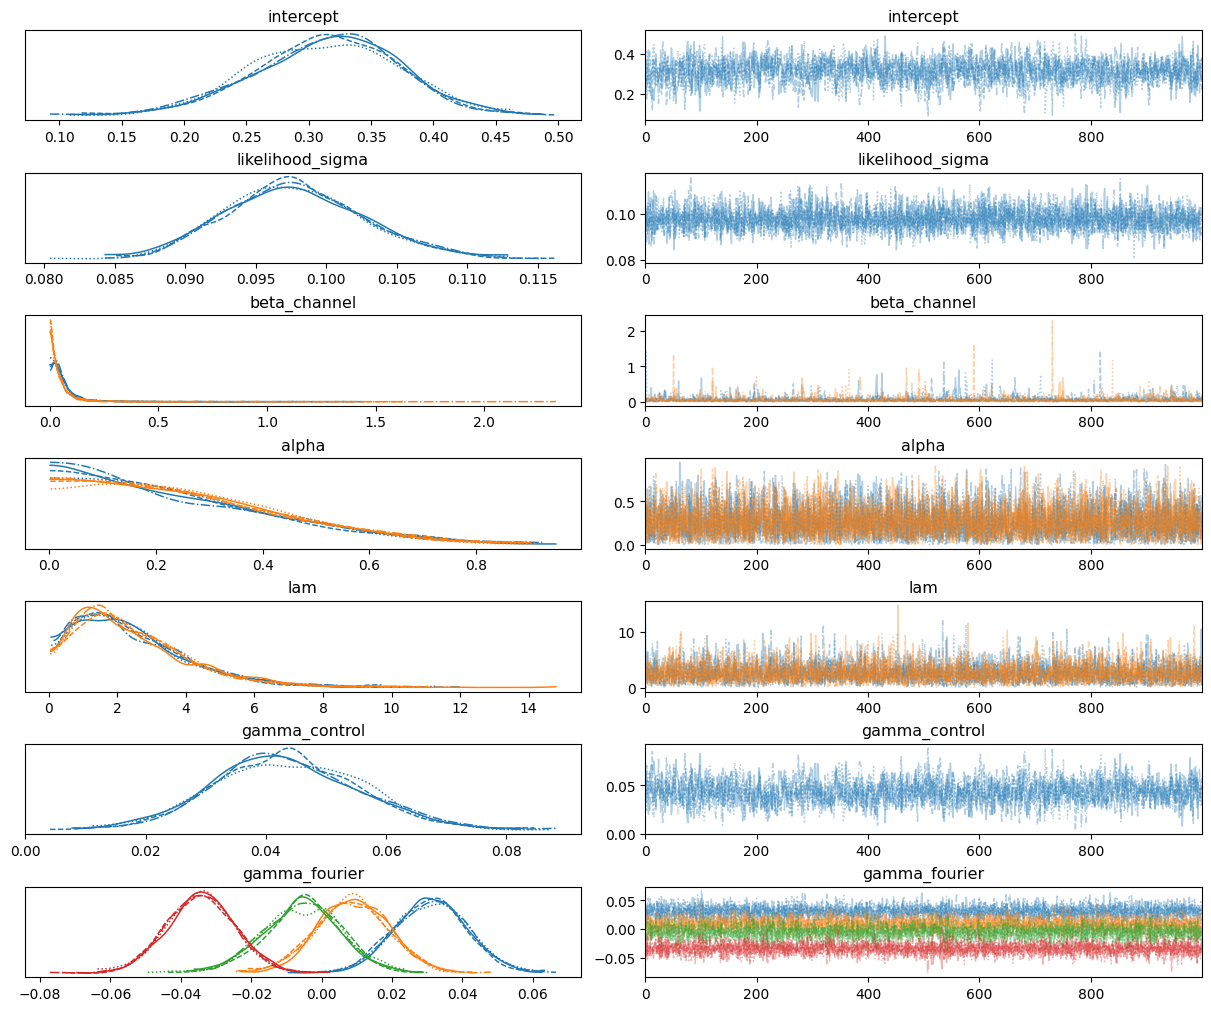

In [19]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [20]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 7MB
Dimensions:  (date: 208, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2021-01-03 2021-01-10 ... 2024-12-22
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 7MB 3.031e+03 2.797e+03 ... 2.228e+03
Attributes:
    created_at:                 2024-05-22T00:50:25.141776+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

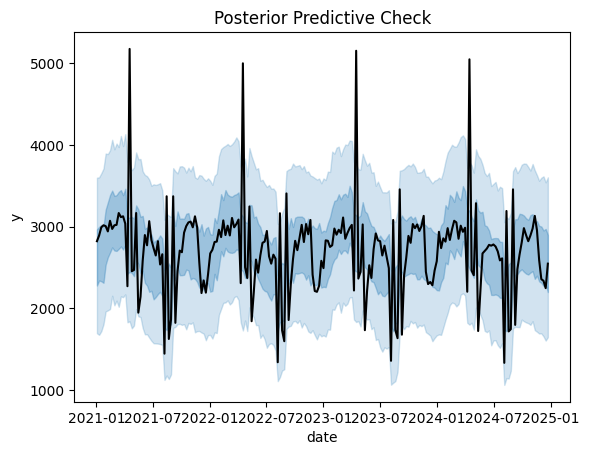

In [21]:
mmm.plot_posterior_predictive(original_scale=True);

In [22]:
mmm.plot_errors(original_scale=True);

AttributeError: 'DelayedSaturatedMMM' object has no attribute 'plot_errors'